In [2]:
import numpy as np
import scipy as sp
import scipy.interpolate
import skimage as ski
import skimage.color, skimage.filters

import matplotlib.pyplot as plt

## Load image

Load the image and make sure it is grayscale.

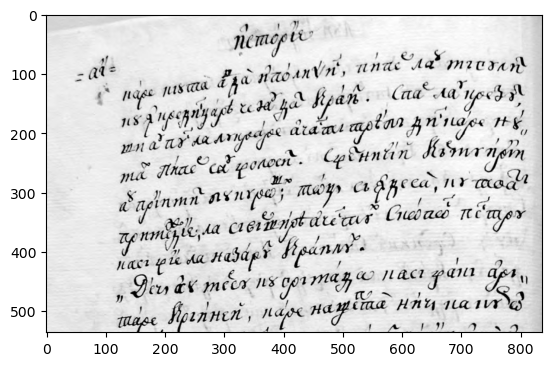

In [3]:
I = plt.imread('Rows.png')
I = ski.color.rgb2gray(I)
plt.imshow(I, cmap='gray')

Let's invert the image, so that the text is white in a black background

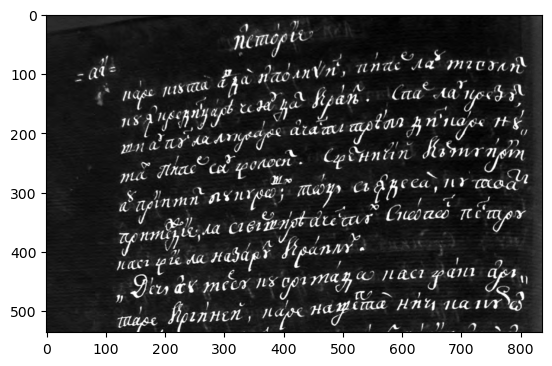

In [4]:
maxval = np.max(I)
Iinv = maxval - I
plt.imshow(Iinv, cmap='gray')

## Filter the image

We apply Gaussian filtering, with an elliptic kernel. 

Below is the kernel used:

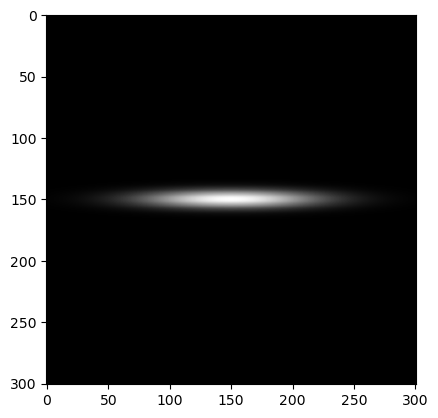

In [6]:
Idirac = np.zeros((301,301))
Idirac[150,150] = 1
Ikernel = ski.filters.gaussian(Idirac, sigma=[5, 50])
plt.imshow(Ikernel, cmap='gray')


The filtered image is:

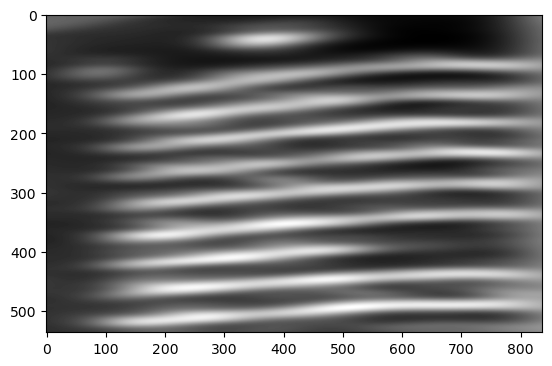

In [7]:
If = ski.filters.gaussian(Iinv, sigma=[5, 50])
plt.figure()
plt.imshow(If, cmap='gray')


## Find ridges

Select a vertical band in the middle of the page, in order to make sure we catch all the lines, and compute its histogram.

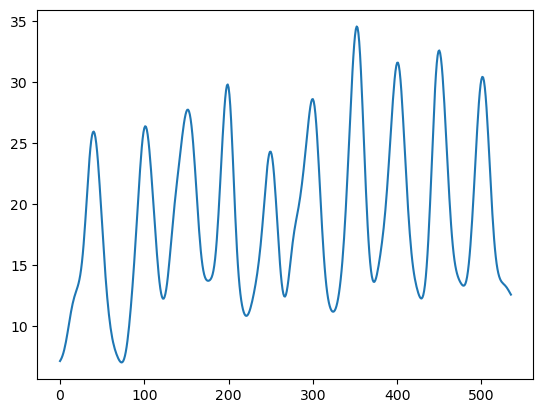

In [8]:
band_mid = int(I.shape[1] / 2)
band_halfwidth = 50

h = np.sum(If[:, band_mid-band_halfwidth:band_mid+band_halfwidth], axis=1)
plt.plot(h)

The peaks in the histogram correspond to the rows. 

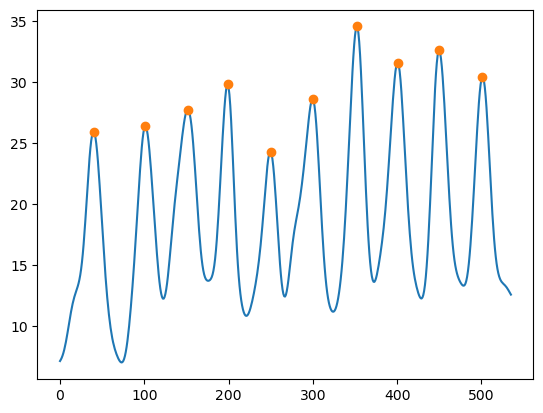

In [15]:
peaks, _ = scipy.signal.find_peaks(h)
plt.plot(h)
plt.plot(peaks, h[peaks], "o")

We define a function to follow the ridge, starting from a given point.

In [16]:
import numpy as np

def ridge_following(I, start_point, max_stride=1, stop_thresh = 0.5):
    """Follow a ridge in the image, starting from a given point, going both left and right

    Args:
        I: the image
        start_point: one point on the ridge
        max_stride (int, optional): local window where to search for the next point on the ridge. Defaults to 1.
        stop_thresh (float, optional): stop ridge when next point is smaller than (stop_thresh * max value) on the ridge

    Returns:
        a vector with the row coordinates of points on the ridge
    """

    assert len(I.shape)==2
    cols = I.shape[1]

    start_row, start_col = start_point

    # Prepare output vector, start with -1
    ridge = -1 * np.ones(cols, dtype=int)
    ridge[start_col] = start_row

    # Follow ridge to the right of start_point
    max_value = I[start_row, start_col]
    for i in range(start_col+1, cols):
        
        ridge[i] = ridge[i-1] - max_stride + np.argmax(I[ridge[i-1] - max_stride : ridge[i-1] + max_stride + 1, i])

        # Update max value
        max_value = max(max_value, I[ridge[i],i])

        # Check termination
        if I[ridge[i],i] < stop_thresh * max_value:
            ridge[i] = -1
            break

    # Follow ridge to the left of start_point
    max_value = I[start_row, start_col]
    for i in range(start_col-1, -1, -1):

        ridge[i] = ridge[i+1] - max_stride + np.argmax(I[ridge[i+1] - max_stride : ridge[i+1] + max_stride + 1, i])

        # Update max value
        max_value = max(max_value, I[ridge[i],i])

        # Check termination
        if I[ridge[i],i] < stop_thresh * max_value:
            ridge[i] = -1
            break

    return ridge


Now let's apply the ridge extraction on the image, starting on the peak points found earlier.

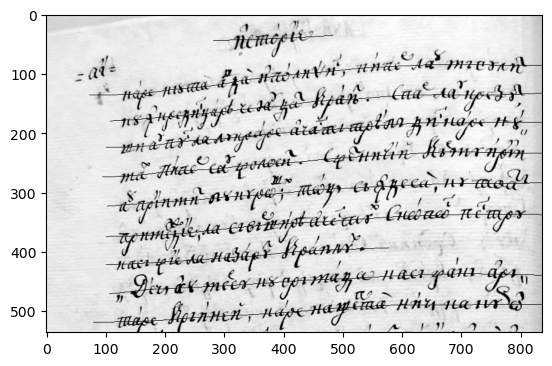

In [18]:
If2 = np.copy(I)

# Follow ridges and plot
ridges = []
for peak in peaks:

    ridge = ridge_following(If, [peak, band_mid], stop_thresh=0.5)

    # Mark on figure
    for c in range(If2.shape[1]):
        if ridge[c] != -1:
            If2[ridge[c],c] = 0

    ridges.append(ridge)

plt.figure()
plt.imshow(If2, cmap='gray')

## Spline smoothing

We can smooth and approximate each ridge in different ways.

For example we can use splines of degree 1, i.e. approximate as a piecewise linear signal.

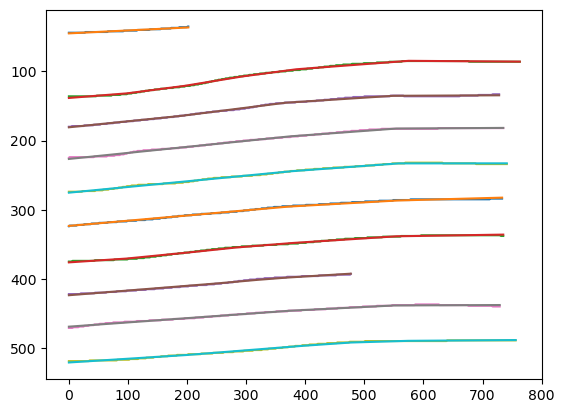

In [30]:
# Smoothing
for ridge in ridges:

    # Limit to part != -1
    x = np.array(range(I.shape[1]))
    x = x[ridge != -1]    
    ridge = ridge[ridge != -1]

    spl = sp.interpolate.UnivariateSpline(x, ridge, k=1, s=len(x)/2)
    plt.plot(ridge)
    plt.plot(spl(x))
plt.gca().invert_yaxis()
plt.show()

Zooming on one of the ridges:

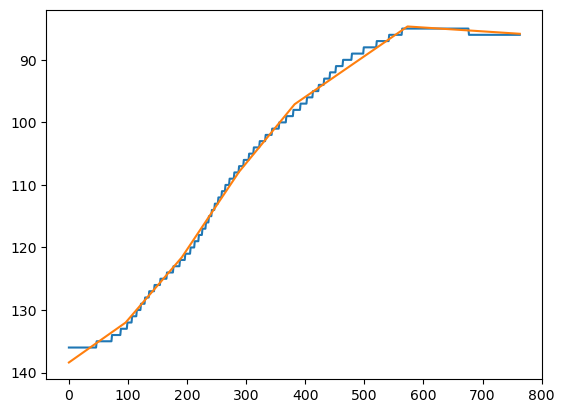

In [31]:
ridge = ridges[1]
    
# Limit to part != -1
x = np.array(range(I.shape[1]))
x = x[ridge != -1]    
ridge = ridge[ridge != -1]

spl = sp.interpolate.UnivariateSpline(x, ridge, k=1, s=len(x)/2)
plt.plot(ridge)
plt.plot(spl(x))

plt.gca().invert_yaxis()
plt.show()